# Cross Validation
This notebook describes how to do cross validation with simulation models.

In [1]:
%matplotlib inline
import tellurium as te
import numpy as np
import lmfit   # Fitting lib
import math
import random 
import matplotlib.pyplot as plt

In [2]:
# Experimental conditions
sim_time = 30
num_points = 10
noise_std = 0.5
num_folds = 3

In [3]:
# The simulation model
rr = te.loada("""
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.15
     k2 = 0.2
""")

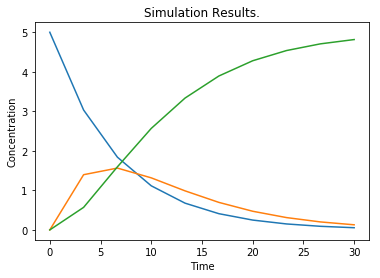

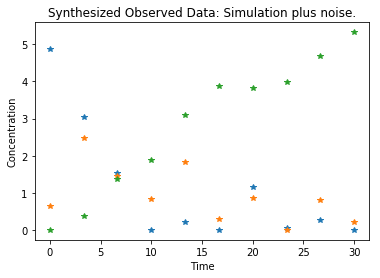

In [4]:
# Create the experimental data. We refer to these as the observations
rr.reset()
data = rr.simulate(0, sim_time, num_points)
num_cols = len(data.colnames) - 1

# Create some 'experimental' data 
x_data = data[:, 0]  # Times
obs_data = data.copy()
obs_data = obs_data[:,1:]   # Values of chemical species

for i in range (num_points):
    for j in range(num_cols):
        obs_data[i, j] = max(obs_data[i, j] + np.random.normal(0, noise_std, 1), 0)
        

# Plot the simulation data.
plt.plot (x_data, data[:, 1:])
plt.title("Simulation Results.")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show() 

# Plot the observed data.
plt.plot (x_data, obs_data, marker='*', linestyle='None')
plt.title("Synthesized Observed Data: Simulation plus noise.")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.show() 


In [5]:
# Generates indices of training and test data
# by alternating between folds
def foldGenerator(num_points, num_folds):
   indices = range(num_points)
   for remainder in range(num_folds):
       test_indices = []
       for idx in indices:
         if idx % num_folds == remainder:
           test_indices.append(idx)
       train_indices = np.array(
           list(set(indices).difference(test_indices)))
       test_indices = np.array(test_indices)
       yield train_indices, test_indices

In [6]:
# Some useful functions

def reshapeData(matrix, indices, first_col=0):
    """
    Re-structures matrix as an array for just the rows
    in indices.
    """
    num_columns = np.shape(matrix)[1] - first_col
    trimmed_matrix = matrix[indices, first_col:]
    return np.reshape(trimmed_matrix, num_columns*len(indices))

def arrayDifference(matrix1, matrix2, indices):
    """
    Calculates matrix1 - matrix2 as a nX1 array for the rows
    specified in indices.
    """
    array1 = reshapeData(matrix1, indices)
    array2 = reshapeData(matrix2, indices)
    return (array1 - array2)

def runSimulation(parameters):
    """
    Runs the simulation model rr for the parameters.
    Returns the simulation data
    """
    rr.reset()
    parameter_dict = parameters.valuesdict()
    rr.k1 = parameter_dict['k1']
    rr.k2 = parameter_dict['k2']
    return rr.simulate (0, sim_time, num_points)


In [7]:
fold_generator = foldGenerator(num_points, num_folds)  # Create the iterator object
result_parameters = []
result_rsqs = []
for train_indices, test_indices in fold_generator:
    
    # This function is defined inside the loop because it references a loop variable
    def calcResiduals(parameters):
        """
        Runs a simulation with the specified parameters and calculates residuals
        for the train_indices.
        """
        sim_data = runSimulation(parameters)
        sim_data = sim_data[:, 1:]  # Skip time
        return arrayDifference(obs_data, sim_data, train_indices)
 
    # Set the parameters
    parameters = lmfit.Parameters()
    parameters.add('k1', value=1, min=0, max=10)
    parameters.add('k2', value=1, min=0, max=10)
    # Estimate the parameters for this fold
    fitter = lmfit.Minimizer(calcResiduals, parameters)
    fitter_result = fitter.minimize(method='leastsq')
    result_parameters.append(fitter_result.params)
    # Run the simulation using
    # the parameters estimated using the training data.
    test_estimates = runSimulation(fitter_result.params)
    test_estimates = test_estimates[:, 1:]
    # Calculate RSQ
    test_residuals = arrayDifference(obs_data, test_estimates, test_indices)
    rsq = 1 - np.var(test_residuals)/np.var(reshapeData(obs_data, test_indices))
    result_rsqs.append(rsq)
    

In [8]:
# R square values for each fold
print(result_rsqs)

[0.9092941678429964, 0.33731779924323135, 0.9347347662098354]


In [9]:
# Parameters for each fold
for parameter in result_parameters:
    print(parameter)

Parameters([('k1', <Parameter 'k1', value=0.18005172658595747 +/- 0.02, bounds=[0:10]>), ('k2', <Parameter 'k2', value=0.1480174317387678 +/- 0.018, bounds=[0:10]>)])
Parameters([('k1', <Parameter 'k1', value=9.997423085253498 +/- 0.984, bounds=[0:10]>), ('k2', <Parameter 'k2', value=0.09842952746432154 +/- 0.0157, bounds=[0:10]>)])
Parameters([('k1', <Parameter 'k1', value=0.18715527458415093 +/- 0.0303, bounds=[0:10]>), ('k2', <Parameter 'k2', value=0.13532871779986133 +/- 0.0204, bounds=[0:10]>)])


**Observations**
1. Parameter estimates are more accurate with a better model (higher R-square)
1. Increasing noise_std degrades the model (lower R square). (Run the notebook for noise_std as 0.8. As 0.1.)